# 3
Same explanations as problem 2 as far as SVHN, batch size, learning rate and number of epochs are concerned.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

We need to implement the Convolution Block in a class. This class must extend `nn.Module`. We have to implement `2` methods:
- `__init__(self)`:
    - first thing must be calling `super().__init__()`
    - then we define all the layers in the figure
- `forward(self, input)`:
    - here we must use the layers we defined in `__init__` to implement the network
    - we have to follow the directions of the arrows in the figure

In [2]:
class ConvolutionalBlock(nn.Module):
    def __init__(self):
        super().__init__()

        self.left_conv = nn.Conv2d(3, 64, kernel_size=3, padding = 1)
        self.left_relu = nn.ReLU()

        self.right_conv = nn.Conv2d(3, 32, kernel_size=3, padding = 1)
        
        self.right_conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.batchnorm = nn.BatchNorm2d(64)
        self.right_relu = nn.ReLU()

    def forward(self, input):
        # input shape is 3 x 32 x 32
        left_output = self.left_conv(input)
        # 64 x 32 x 32
        left_output = self.left_relu(left_output)

        right_output = self.right_conv(input)
        right_output = self.right_conv2(right_output)
        right_output = self.batchnorm(right_output)
        right_output = self.right_relu(right_output)
        # 64 x 32 x 32

        output = left_output + right_output
        # 64 x 32 x 32
        return output

In [3]:
net = nn.Sequential(
    ConvolutionalBlock(),
    nn.Flatten(),
    # error multiplying mat1 and mat2
    # where mat1 is of shape 256 x bla
    nn.Linear(64*32*32, 10)
    )
net

Sequential(
  (0): ConvolutionalBlock(
    (left_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (left_relu): ReLU()
    (right_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (right_conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (right_relu): ReLU()
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=65536, out_features=10, bias=True)
)

In [4]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.SVHN(
        root="../data", split="train", transform=trans, download=True)
    mnist_test = torchvision.datasets.SVHN(
        root="../data", split="test", transform=trans, download=True)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [43257, 30000],
                                                           generator=torch.Generator().manual_seed(42))
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_val, batch_size, shuffle=False,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

In [5]:
def evaluate_accuracy(net, data_iter, loss, device):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100

In [6]:
def train_epoch(net, train_iter, loss, optimizer, device):
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training correct predictions, no. of examples
    total_loss = 0
    total_hits = 0
    total_samples = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += float(l)
        total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
        total_samples += y.numel()
    # Return training loss and training accuracy
    return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100

In [7]:
def train(net, train_iter, val_iter, test_iter, num_epochs, lr, device):
    """Train a model."""
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('Training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer, device)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter, loss, device)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')
    test_loss, test_acc = evaluate_accuracy(net, test_iter, loss, device)
    print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

In [8]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [9]:
def plot_loss(train_loss_all, val_loss_all):
    epochs = range(1, len(train_loss_all) + 1)
    plt.plot(epochs, train_loss_all, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_all, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [10]:
def plot_accuracy(train_acc_all, val_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_all, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
batch_size, lr, num_epochs = 256, 0.05, 5
train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size)
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, test_iter, num_epochs, lr, try_gpu()) #2 min

Using downloaded and verified file: ../data\train_32x32.mat
Using downloaded and verified file: ../data\test_32x32.mat
Training on cuda:0
Epoch 1, Train loss 4.92, Train accuracy 18.15, Validation loss 2.24, Validation accuracy 19.09
Epoch 2, Train loss 2.23, Train accuracy 19.28, Validation loss 2.23, Validation accuracy 19.66
Epoch 3, Train loss 2.20, Train accuracy 21.46, Validation loss 2.55, Validation accuracy 14.17
Epoch 4, Train loss 2.03, Train accuracy 30.65, Validation loss 2.47, Validation accuracy 19.15


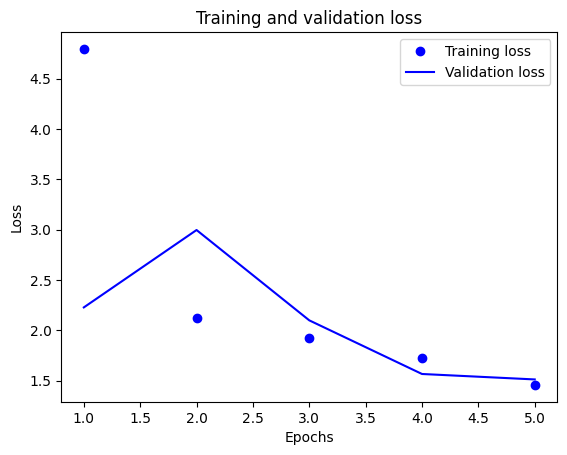

In [ ]:
plot_loss(train_loss_all, val_loss_all)

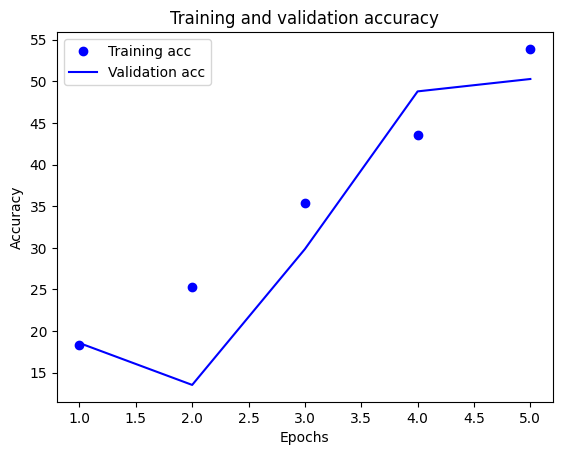

In [ ]:
plot_accuracy(train_acc_all, val_acc_all)